# Chapter 7

In [48]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn import preprocessing as pre
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [20]:
az.style.use('arviz-darkgrid')

In [9]:
sppnames =  ["afarensis","africanus","habilis","boisei", "rudolfensis","ergaster","sapiens"]
brainvolcc = [438 , 452 , 612, 521, 752, 871, 1350]
masskg = [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]
df = pd.DataFrame({'species' : sppnames, 'brain' : brainvolcc, 'mass' :masskg})


In [10]:
df.head()

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5


In [25]:
df['brain_s'] = df['brain']/df['brain'].max()
df['mass_s'] = pre.scale(df['mass'])

In [26]:
df.head()

,species,brain,mass,brain_s,mass_s
0,afarensis,438,37.0,0.324444,-0.841920
1,africanus,452,35.5,0.334815,-0.990494
2,habilis,612,34.5,0.453333,-1.089544
3,boisei,521,41.5,0.385926,-0.396198
4,rudolfensis,752,55.5,0.557037,0.990494


Define our linear model:

$$ b_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i \sim \alpha + bm_{i} $$
$$ \alpha \sim Normal(0.5, 1) $$
$$ \beta \sim Normal(0,10) $$
$$ \sigma \sim Log \textrm{-} Normal(0,1) $$

In [56]:
with pm.Model() as m71:
    sigma = pm.Lognormal('sigma',0,1)
    beta = pm.Normal('beta',0,10)
    alpha = pm.Normal('alpha',0.5,1)
    mu = pm.Deterministic('mu',alpha + beta* df['mass_s'])
    brain_s = pm.Normal('brain', mu, sigma, observed = df.brain_s)
    trace71 = pm.sample(1000, tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1613.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D938E3F160>,
      dtype=object)

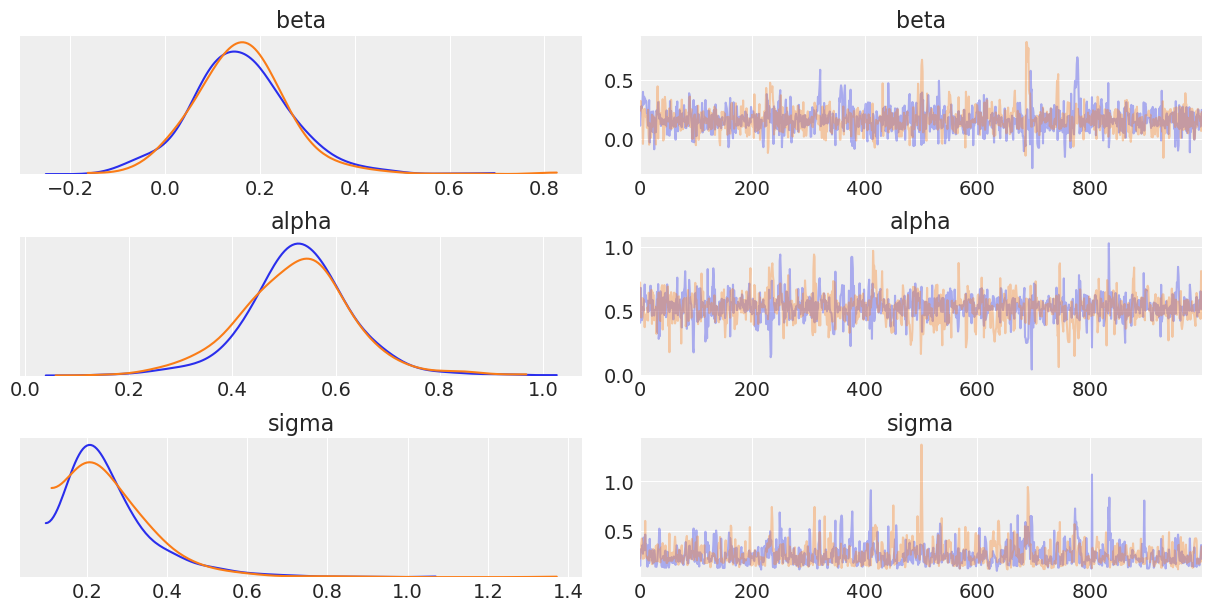

In [28]:
az.plot_trace(trace71, var_names = ['~mu'])

In [96]:
def r2_is_bad(trace, shape = 1):
    if shape == 1:
        residual = df['brain_s'] - (trace.alpha.mean() + trace.beta.mean()* df['mass_s'] )
        resid_var = np.var(residual, ddof = 0)
        outcome_var = np.var(df['brain_s'], ddof= 0)
        return 1-resid_var/outcome_var

In [42]:
r2_is_bad(trace71)

0.49015529041671324

In [46]:
with pm.Model() as m72:
    sigma = pm.Lognormal('sigma',0,1)
    beta = pm.Normal('beta',0,10, shape = 2) 
    alpha = pm.Normal('alpha',0.5,1)
    mu = pm.Deterministic('mu',alpha + beta[0] * df['mass_s'] + beta[1] * df['mass_s'] ** 2)
    brain_s = pm.Normal('brain', mu, sigma, observed = df.brain_s)
    trace72 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as m73:
    sigma = pm.Lognormal('sigma',0,1)
    beta = pm.Normal('beta',0,10, shape = 3) 
    alpha = pm.Normal('alpha',0.5,1)
    mu = pm.Deterministic('mu',alpha + beta[0] * df['mass_s'] + beta[1] * df['mass_s'] ** 2 +
    beta[2] * df['mass_s'] ** 3)
    brain_s = pm.Normal('brain', mu, sigma, observed = df.brain_s)
    trace73 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as m74:
    sigma = pm.Lognormal('sigma',0,1)
    beta = pm.Normal('beta',0,10, shape = 4) 
    alpha = pm.Normal('alpha',0.5,1)
    mu = pm.Deterministic('mu',alpha + beta[0] * df['mass_s'] + beta[1] * df['mass_s'] ** 2 +
    beta[2] * df['mass_s'] ** 3 + beta[3] * df['mass_s'] ** 4)
    brain_s = pm.Normal('brain', mu, sigma, observed = df.brain_s)
    trace74 = pm.sample(1000, tune = 1000, cores = 1)
    
    
with pm.Model() as m75:
    sigma = pm.Lognormal('sigma',0,1)
    beta = pm.Normal('beta',0,10, shape = 5) 
    alpha = pm.Normal('alpha',0.5,1)
    mu = pm.Deterministic('mu',alpha + beta[0] * df['mass_s'] + beta[1] * df['mass_s'] ** 2 +
    beta[2] * df['mass_s'] ** 3 + beta[3] * df['mass_s'] ** 4 + beta[4] * df['mass_s'] ** 5)
    brain_s = pm.Normal('brain', mu, sigma, observed = df.brain_s)
    trace75 = pm.sample(1000, tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 955.84it/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7010541325849299, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 452.41it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameteriz

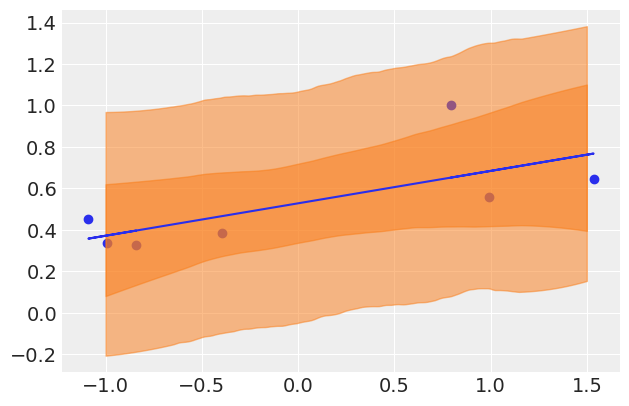

In [59]:
plt.scatter(df['mass_s'], df['brain_s'])
plt.plot(df['mass_s'],trace71['alpha'].mean() +trace71['beta'].mean()* df['mass_s'])
x_points = np.linspace(-1,1.5,100)
mu_pred = trace71['alpha'] + trace71['beta'] * x_points[:,None]
az.plot_hpd(x_points, mu_pred.T)
brain_pred = stats.norm.rvs(mu_pred, trace71['sigma'])
az.plot_hpd(x_points, brain_pred.T)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2865.56it/s]


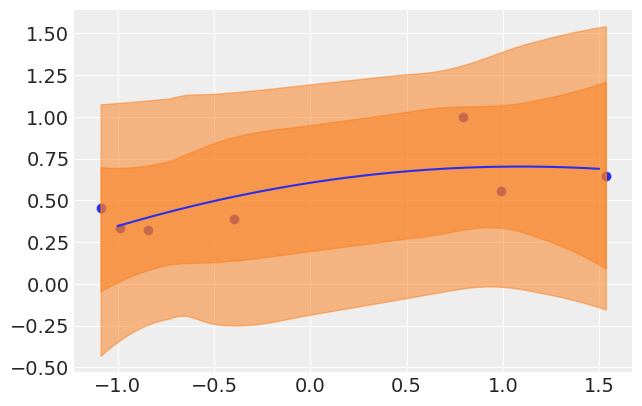

In [80]:
plt.scatter(df['mass_s'], df['brain_s'])

brain_pred = pm.sample_posterior_predictive(trace72, 200, m72)

x_points = np.linspace(-1,1.5,100)
mu_pred = trace72['alpha'].mean() + trace72['beta'][:,0].mean() * x_points[:,None] + trace72['beta'][:,1].mean() * x_points[:,None] **2

#az.plot_hpd(x_points, mu_pred.T)
#brain_pred = stats.norm.rvs(mu_pred, trace72['sigma'])
#az.plot_hpd(x_points, brain_pred.T)

plt.plot(x_points, mu_pred)

az.plot_hpd(df['mass_s'], brain_pred['brain'])
az.plot_hpd(df['mass_s'], trace72.mu)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3085.11it/s]


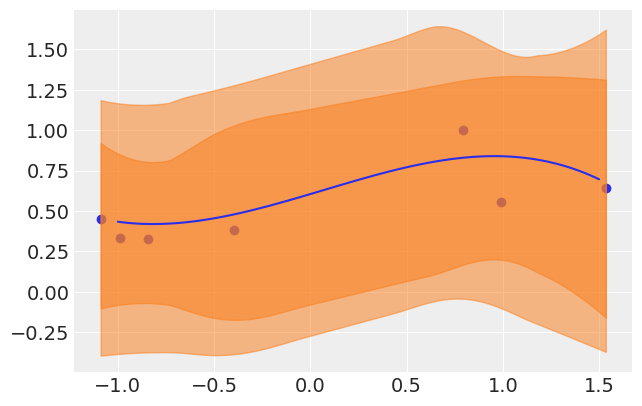

In [84]:
plt.scatter(df['mass_s'], df['brain_s'])

brain_pred = pm.sample_posterior_predictive(trace73, 200, m73)

x_points = np.linspace(-1,1.5,100)
mu_pred = trace72['alpha'].mean() + trace73['beta'][:,0].mean() * x_points[:,None] + \
trace73['beta'][:,1].mean() * x_points[:,None] **2 + \
trace73['beta'][:,2].mean() * x_points[:,None] **3 


#az.plot_hpd(x_points, mu_pred.T)
#brain_pred = stats.norm.rvs(mu_pred, trace72['sigma'])
#az.plot_hpd(x_points, brain_pred.T)

plt.plot(x_points, mu_pred)

az.plot_hpd(df['mass_s'], brain_pred['brain'])
az.plot_hpd(df['mass_s'], trace73.mu)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2304.97it/s]


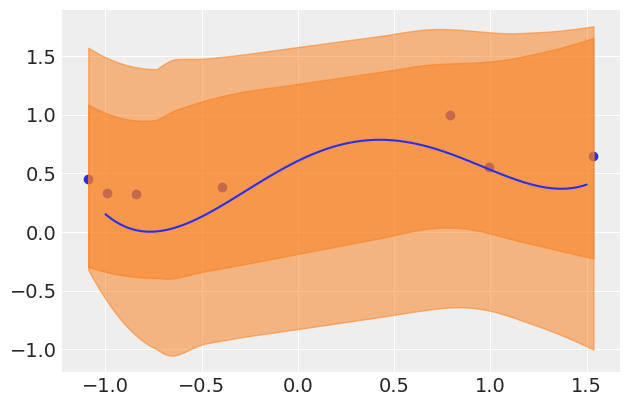

In [89]:
plt.scatter(df['mass_s'], df['brain_s'])

brain_pred = pm.sample_posterior_predictive(trace74, 200, m74)

x_points = np.linspace(-1,1.5,100)
mu_pred = trace72['alpha'].mean() + trace74['beta'][:,0].mean() * x_points[:,None] + \
trace74['beta'][:,1].mean() * x_points[:,None] **2 + \
trace74['beta'][:,2].mean() * x_points[:,None] **3 + \
trace74['beta'][:,3].mean() * x_points[:,None] **4


#az.plot_hpd(x_points, mu_pred.T)
#brain_pred = stats.norm.rvs(mu_pred, trace72['sigma'])
#az.plot_hpd(x_points, brain_pred.T)

plt.plot(x_points, mu_pred)

az.plot_hpd(df['mass_s'], brain_pred['brain'])
az.plot_hpd(df['mass_s'], trace74.mu)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2110.18it/s]


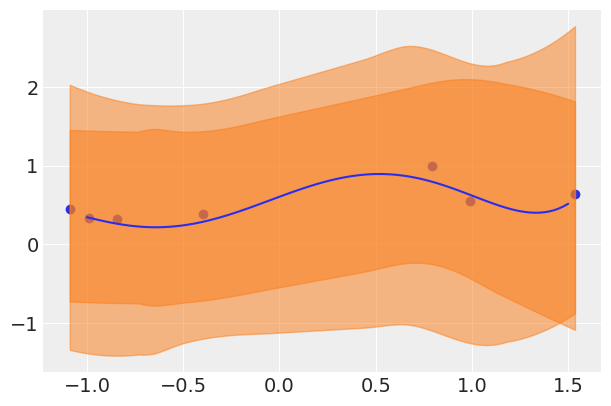

In [92]:
plt.scatter(df['mass_s'], df['brain_s'])

brain_pred = pm.sample_posterior_predictive(trace75, 200, m75)

x_points = np.linspace(-1,1.5,100)
mu_pred = trace72['alpha'].mean() + trace75['beta'][:,0].mean() * x_points[:,None] + \
trace75['beta'][:,1].mean() * x_points[:,None] **2 + \
trace75['beta'][:,2].mean() * x_points[:,None] **3 + \
trace75['beta'][:,3].mean() * x_points[:,None] **4 + \
trace75['beta'][:,4].mean() * x_points[:,None] **5


#az.plot_hpd(x_points, mu_pred.T)
#brain_pred = stats.norm.rvs(mu_pred, trace72['sigma'])
#az.plot_hpd(x_points, brain_pred.T)

plt.plot(x_points, mu_pred)

az.plot_hpd(df['mass_s'], brain_pred['brain'])
az.plot_hpd(df['mass_s'], trace75.mu)

In [93]:
r2_is_bad(trace75)

0.018911614898068252

In [97]:
residual = df['brain_s'] - (trace75['alpha'].mean() + \
trace75['beta'][:,0].mean() * df['mass_s'] + \
trace75['beta'][:,1].mean() * df['mass_s'] **2 + \
trace75['beta'][:,2].mean() * df['mass_s'] **3 + \
trace75['beta'][:,3].mean() * df['mass_s'] **4 + \
trace75['beta'][:,4].mean() * df['mass_s'] **5 )
resid_var = np.var(residual, ddof = 0)
outcome_var = np.var(df['brain_s'], ddof= 0)
1-resid_var/outcome_var

0.8715830618200773

In [99]:
residual = df['brain_s'] - (trace74['alpha'].mean() + \
trace74['beta'][:,0].mean() * df['mass_s'] + \
trace74['beta'][:,1].mean() * df['mass_s'] **2 + \
trace74['beta'][:,2].mean() * df['mass_s'] **3 + \
trace74['beta'][:,3].mean() * df['mass_s'] **4 )
resid_var = np.var(residual, ddof = 0)
outcome_var = np.var(df['brain_s'], ddof= 0)
1-resid_var/outcome_var

0.8038424747994813

In [100]:
residual = df['brain_s'] - (trace73['alpha'].mean() + \
trace73['beta'][:,0].mean() * df['mass_s'] + \
trace73['beta'][:,1].mean() * df['mass_s'] **2 + \
trace73['beta'][:,2].mean() * df['mass_s'] **3 )
resid_var = np.var(residual, ddof = 0)
outcome_var = np.var(df['brain_s'], ddof= 0)
1-resid_var/outcome_var

0.6759535161172369

In [101]:
residual = df['brain_s'] - (trace72['alpha'].mean() + \
trace72['beta'][:,0].mean() * df['mass_s'] + \
trace72['beta'][:,1].mean() * df['mass_s'] **2 )
resid_var = np.var(residual, ddof = 0)
outcome_var = np.var(df['brain_s'], ddof= 0)
1-resid_var/outcome_var

0.5358041859122133

In [106]:
p = [0.3 , 0.7]
-np.sum(p*np.log(p))

0.6108643020548935